## Seasonal SAT&SLP kernel density function during three 65yrs periods 

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as smm
import os
import sys


In [2]:
# defintion of the functions used in this notebook
from scipy.stats import linregress
def calc_trend(data):
    slope, intercept, r_value, p_value, std_err = linregress(np.arange(len(data)), data)  
    return slope, p_value

# def calc_seasonal_means(data, season):
   
#     if season == 'JJA':
#         months = [6,7,8]
#     elif season == 'DJF':
#         months =[12,1,2]
#     elif season == 'MAM':
#         months = [3,4,5]
#     elif season == 'SON':
#         months = [9,10,11]


#     season_months = data.sel(time=data.time.dt.month.isin(months))
    
#     # Calculate the seasonal mean SAT anomalies
#     season_mean_anomalies = season_months.groupby('time.year').mean('time')

#     seasons = ['JJA', 'DJF', 'MAM', 'SON']

#     for season in seasons:
#         data[f'{season}'] = season_mean_anomalies['tas']

#     return data


def calc_seasonal_std(data):
    # Define the seasons
    seasons = ['DJF', 'MAM', 'JJA', 'SON']
    season_stds = {}

    for season in seasons:
        if season == 'JJA':
            months = [6,7,8]
        elif season == 'DJF':
            months =[12,1,2]
        elif season == 'MAM':
            months = [3,4,5]
        elif season == 'SON':
            months = [9,10,11]

    season_months = data.sel(time=data.time.dt.month.isin(months))

    # Calculate the seasonal mean SAT anomalies
    season_std_anomalies = season_months.groupby('time.year').std('time')

    return season_std_anomalies

### Main script 

In [ ]:
#observational SLP&SAT trends


In [3]:
data_hist_ssp245_MPI_ESM  = '/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/MergeDataOut/tas_Amon_1850-2100_*.nc'
ds = xr.open_mfdataset(data_hist_ssp245_MPI_ESM, combine = 'nested', concat_dim = 'run')
ds

<xarray.Dataset>
Dimensions:    (time: 3012, run: 30, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2100-12-16T12:00:00
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    height     float64 2.0
Dimensions without coordinates: run, bnds
Data variables:
    time_bnds  (run, time, bnds) datetime64[ns] dask.array<chunksize=(1, 3012, 2), meta=np.ndarray>
    tas        (run, time, lat, lon) float32 dask.array<chunksize=(1, 3012, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.6 (https://mpi...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/6b679cba-17b8-45eb-90dc-23d170c1998c
    CDO:                    Climate Data Operators version 2.0.6 (https://mpi...

In [4]:
#Perfrom land sea mask
land_sea_mask=xr.open_dataset('/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/GR15_lsm_regrid.nc')

mask_data = land_sea_mask['var1']
display(mask_data)
# Align the time coordinates between the mask dataset and the original dataset
time_values = pd.to_datetime(mask_data['time'].values, format='mixed', dayfirst=True)
mask_data['time'] = time_values

mask_data = mask_data.reindex(time=ds['time'], method='nearest')
# Apply the land-sea mask to the original dataset
masked_tas = ds.where(mask_data == 1, drop=False)
masked_tas

<xarray.DataArray 'var1' (time: 1, lat: 90, lon: 180)>
[16200 values with dtype=float32]
Coordinates:
  * time     (time) float64 201.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Attributes:
    code:     1

<xarray.Dataset>
Dimensions:    (run: 30, time: 3012, bnds: 2, lat: 90, lon: 180)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2100-12-16T12:00:00
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    height     float64 2.0
Dimensions without coordinates: run, bnds
Data variables:
    time_bnds  (run, time, bnds, lat, lon) datetime64[ns] dask.array<chunksize=(1, 3012, 2, 90, 180), meta=np.ndarray>
    tas        (run, time, lat, lon) float32 dask.array<chunksize=(1, 3012, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.6 (https://mpi...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/6b679cba-17b8-45eb-90dc-23d170c1998c
    CDO:                    Climate Data Operators version 2.0.6 (https://mpi...

In [5]:
# Three non-overlapping periods: 1892-1957, 1958-2022, 2023-2087
# KDEs of the three periods are compared in this notebook.

tas= masked_tas['tas'].loc[:,'1892-01-01':'2100-12-31',0:90,:]
tas = tas - 273.15
print(tas.min().values)
tas_climatology = tas.groupby('time.month').mean(dim='time')

tas_ano = tas.groupby('time.month') - tas_climatology
tas_ano_ds = tas_ano.to_dataset()
tas_ano_ds

-53.34633


/home/m/m301036/.conda/envs/mykernel/lib/python3.9/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 209 times more chunks
  return self.array[key]


<xarray.Dataset>
Dimensions:  (time: 2508, lon: 180, lat: 45, run: 30)
Coordinates:
  * time     (time) datetime64[ns] 1892-01-16T12:00:00 ... 2100-12-16T12:00:00
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: run
Data variables:
    tas      (run, time, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>

In [6]:
tas_P1 = tas_ano_ds.sel(time=slice('1893-01-01','1957-12-31'))
tas_P2 = tas_ano_ds.sel(time=slice('1958-01-01','2022-12-31'))
tas_P3 = tas_ano_ds.sel(time=slice('2023-01-01','2087-12-31'))

display(tas_P1), display(tas_P2), display(tas_P3)

<xarray.Dataset>
Dimensions:  (time: 780, lon: 180, lat: 45, run: 30)
Coordinates:
  * time     (time) datetime64[ns] 1893-01-16T12:00:00 ... 1957-12-16T12:00:00
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: run
Data variables:
    tas      (run, time, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>

<xarray.Dataset>
Dimensions:  (time: 780, lon: 180, lat: 45, run: 30)
Coordinates:
  * time     (time) datetime64[ns] 1958-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: run
Data variables:
    tas      (run, time, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>

<xarray.Dataset>
Dimensions:  (time: 780, lon: 180, lat: 45, run: 30)
Coordinates:
  * time     (time) datetime64[ns] 2023-01-16T12:00:00 ... 2087-12-16T12:00:00
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: run
Data variables:
    tas      (run, time, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>

(None, None, None)

In [7]:
seasons = ['JJA', 'DJF', 'MAM', 'SON']
season_means = {}
season_means_P2 = {}
season_means_P3 = {}

for season in seasons:
    if season == 'JJA':
        months = [6,7,8]
    elif season == 'DJF':
        months =[12,1,2]
    elif season == 'MAM':
        months = [3,4,5]
    elif season == 'SON':
        months = [9,10,11]

    season_months = tas_P1.sel(time=tas_P1.time.dt.month.isin(months))
    season_months_P2 = tas_P2.sel(time=tas_P2.time.dt.month.isin(months))
    season_months_P3 = tas_P3.sel(time=tas_P3.time.dt.month.isin(months))
    
    # Calculate the seasonal mean SAT anomalies
    season_mean_anomalies = season_months.groupby('time.year').mean('time')
    season_mean_anomalies_P2 = season_months_P2.groupby('time.year').mean('time')
    season_mean_anomalies_P3 = season_months_P3.groupby('time.year').mean('time')
    
    # Store the seasonal mean in the dictionary
    season_means[season] = season_mean_anomalies['tas']
    season_means_P2[season] = season_mean_anomalies_P2['tas']
    season_means_P3[season] = season_mean_anomalies_P3['tas']

# Access the multiyear JJA mean SAT anomalies
    
tas_P1['JJA'] = season_means['JJA']
tas_P1['DJF'] = season_means['DJF']
tas_P1['MAM'] = season_means['MAM']
tas_P1['SON'] = season_means['SON']

tas_P2['JJA'] = season_means_P2['JJA']
tas_P2['DJF'] = season_means_P2['DJF']
tas_P2['MAM'] = season_means_P2['MAM']
tas_P2['SON'] = season_means_P2['SON']

tas_P3['JJA'] = season_means_P3['JJA']
tas_P3['DJF'] = season_means_P3['DJF']
tas_P3['MAM'] = season_means_P3['MAM']
tas_P3['SON'] = season_means_P3['SON']

tas_P1

<xarray.Dataset>
Dimensions:  (time: 780, lon: 180, lat: 45, run: 30, year: 65)
Coordinates:
  * time     (time) datetime64[ns] 1893-01-16T12:00:00 ... 1957-12-16T12:00:00
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * year     (year) int64 1893 1894 1895 1896 1897 ... 1953 1954 1955 1956 1957
Dimensions without coordinates: run
Data variables:
    tas      (run, time, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    JJA      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    DJF      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    MAM      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    SON      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>

In [8]:
# Calculate the seasonal trend patterns for the three periods LSAT data
# and compare the PDFs of the three periods

# Calculate the trend and p-values for the DJF season of period 1
tas_P1['slope_DJF'], tas_P1['p_values_DJF'] = xr.apply_ufunc(calc_trend, tas_P1['DJF'].chunk(dict(run=-1, year=-1)), 
                                                                               input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})

tas_P2['slope_DJF'], tas_P2['p_values_DJF'] = xr.apply_ufunc(calc_trend, tas_P2['DJF'].chunk(dict(run=-1, year=-1)),
                                                                                 input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})

tas_P3['slope_DJF'], tas_P3['p_values_DJF'] = xr.apply_ufunc(calc_trend, tas_P3['DJF'].chunk(dict(run=-1, year=-1)),
                                                                                    input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})


In [9]:
tas_P1 = tas_P1.compute()
tas_P2 = tas_P2.compute()
tas_P3 = tas_P3.compute()


In [10]:
tas_P1

<xarray.Dataset>
Dimensions:       (time: 780, lon: 180, lat: 45, run: 30, year: 65)
Coordinates:
  * time          (time) datetime64[ns] 1893-01-16T12:00:00 ... 1957-12-16T12...
  * lon           (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat           (lat) float64 1.0 3.0 5.0 7.0 9.0 ... 81.0 83.0 85.0 87.0 89.0
    height        (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0
    month         (time) int64 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
  * year          (year) int64 1893 1894 1895 1896 1897 ... 1954 1955 1956 1957
Dimensions without coordinates: run
Data variables:
    tas           (run, time, lat, lon) float32 nan nan nan nan ... nan nan nan
    JJA           (year, run, lat, lon) float32 nan nan nan nan ... nan nan nan
    DJF           (year, run, lat, lon) float32 nan nan nan nan ... nan nan nan
    MAM           (year, run, lat, lon) float32 nan nan nan nan ... nan nan nan
    SON           (year, run, lat, lon) float32 nan nan nan nan ... nan nan nan
    slope_DJF     (run, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    p_values_DJF  (run, lat, lon) float64 nan nan nan nan ... nan nan nan nan

In [13]:
# remove the MME from the each member of the ensemble

# MME trend values
tas_P1_MME = tas_P1['slope_DJF'].mean(dim='run')
tas_P2_MME = tas_P2['slope_DJF'].mean(dim='run')
tas_P3_MME = tas_P3['slope_DJF'].mean(dim='run')

tas_P1_MME

<xarray.DataArray 'slope_DJF' (lat: 45, lon: 180)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0

In [15]:
# remove the MME from the each member of the ensemble
tas_P1['residual_slope_DJF'] = tas_P1['slope_DJF'] - tas_P1_MME
tas_P2['residual_slope_DJF'] = tas_P2['slope_DJF'] - tas_P2_MME
tas_P3['residual_slope_DJF'] = tas_P3['slope_DJF'] - tas_P3_MME

tas_P1['residual_slope_DJF'].min(), tas_P1['residual_slope_DJF'].max()

(<xarray.DataArray 'residual_slope_DJF' ()>
 array(-0.07563886),
 <xarray.DataArray 'residual_slope_DJF' ()>
 array(0.0652456))

## slp trend patterns

In [16]:
model_SLP = '/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/MergeDataOut/psl_Amon_1850-2100_*.nc'
ds_SLP = xr.open_mfdataset(model_SLP, combine = 'nested', concat_dim = 'run')
print(ds_SLP)
ds_SLP['psl'] = ds_SLP['psl']/100.0
ds_SLP['psl'] = ds_SLP['psl'].assign_attrs(units='hPa')
ds_SLP =ds_SLP.assign_coords(lon=(((ds_SLP.lon + 180) % 360) - 180)).sortby('lon')
ds_SLP

<xarray.Dataset>
Dimensions:    (time: 3012, run: 30, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2100-12-16T12:00:00
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Dimensions without coordinates: run, bnds
Data variables:
    time_bnds  (run, time, bnds) datetime64[ns] dask.array<chunksize=(1, 3012, 2), meta=np.ndarray>
    psl        (run, time, lat, lon) float32 dask.array<chunksize=(1, 3012, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.6 (https://mpi...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...


<xarray.Dataset>
Dimensions:    (time: 3012, run: 30, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2100-12-16T12:00:00
  * lon        (lon) float64 -180.0 -178.0 -176.0 -174.0 ... 174.0 176.0 178.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Dimensions without coordinates: run, bnds
Data variables:
    time_bnds  (run, time, bnds) datetime64[ns] dask.array<chunksize=(1, 3012, 2), meta=np.ndarray>
    psl        (run, time, lat, lon) float32 dask.array<chunksize=(1, 3012, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.6 (https://mpi...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    variable_id:            psl
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/2d4e90e1-d70a-49f4-8374-eb769a0b143d
    CDO:                    Climate Data Operators version 2.0.6 (https://mpi...

In [18]:
slp_ds = ds_SLP['psl'].loc[:,'1893-01-01':'2100-12-31',0:90,:]
print(slp_ds.min().values)
slp_ds_climatology = slp_ds.groupby('time.month').mean(dim='time')
slp_ds_climatology
slp_ano_ds = slp_ds.groupby('time.month') - slp_ds_climatology
slp_ano_ds = slp_ano_ds.to_dataset()
slp_ano_ds

SLP_ano_P1 = slp_ano_ds.sel(time=slice('1893-01-01','1957-12-31'))
SLP_ano_P2 = slp_ano_ds.sel(time=slice('1958-01-01','2022-12-31'))
SLP_ano_P3 = slp_ano_ds.sel(time=slice('2023-01-01','2087-12-31'))

seasons = ['JJA', 'DJF', 'MAM', 'SON']
season_means_SLP_P1 = {}
season_means_SLP_P2 = {}
season_means_SLP_P3 = {}

for season in seasons:
    if season == 'JJA':
        months = [6,7,8]
    elif season == 'DJF':
        months =[12,1,2]
    elif season == 'MAM':
        months = [3,4,5]
    elif season == 'SON':
        months = [9,10,11]

    season_months_SLP = SLP_ano_P1.sel(time=SLP_ano_P1.time.dt.month.isin(months))
    season_months_SLP_P2 = SLP_ano_P2.sel(time=SLP_ano_P2.time.dt.month.isin(months))
    season_months_SLP_P3 = SLP_ano_P3.sel(time=SLP_ano_P3.time.dt.month.isin(months))
    
    # Calculate the seasonal mean SAT anomalies
    season_mean_anomalies_slp = season_months_SLP.groupby('time.year').mean('time')
    season_mean_anomalies_slp_P2 = season_months_SLP_P2.groupby('time.year').mean('time')
    season_mean_anomalies_slp_P3 = season_months_SLP_P3.groupby('time.year').mean('time')
    
    # Store the seasonal mean in the dictionary
    season_means_SLP_P1[season] = season_mean_anomalies_slp['psl']
    season_means_SLP_P2[season] = season_mean_anomalies_slp_P2['psl']
    season_means_SLP_P3[season] = season_mean_anomalies_slp_P3['psl']

# Access the multiyear JJA mean SAT anomalies
    
SLP_ano_P1['JJA'] = season_means_SLP_P1['JJA']
SLP_ano_P1['DJF'] = season_means_SLP_P1['DJF']
SLP_ano_P1['MAM'] = season_means_SLP_P1['MAM']
SLP_ano_P1['SON'] = season_means_SLP_P1['SON']

SLP_ano_P2['JJA'] = season_means_SLP_P2['JJA']
SLP_ano_P2['DJF'] = season_means_SLP_P2['DJF']
SLP_ano_P2['MAM'] = season_means_SLP_P2['MAM']
SLP_ano_P2['SON'] = season_means_SLP_P2['SON']

SLP_ano_P3['JJA'] = season_means_SLP_P3['JJA']
SLP_ano_P3['DJF'] = season_means_SLP_P3['DJF']
SLP_ano_P3['MAM'] = season_means_SLP_P3['MAM']
SLP_ano_P3['SON'] = season_means_SLP_P3['SON']

SLP_ano_P1

970.7837


/home/m/m301036/.conda/envs/mykernel/lib/python3.9/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 208 times more chunks
  return self.array[key]


<xarray.Dataset>
Dimensions:  (time: 780, lon: 180, lat: 45, run: 30, year: 65)
Coordinates:
  * time     (time) datetime64[ns] 1893-01-16T12:00:00 ... 1957-12-16T12:00:00
  * lon      (lon) float64 -180.0 -178.0 -176.0 -174.0 ... 174.0 176.0 178.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * year     (year) int64 1893 1894 1895 1896 1897 ... 1953 1954 1955 1956 1957
Dimensions without coordinates: run
Data variables:
    psl      (run, time, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    JJA      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    DJF      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    MAM      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    SON      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>

In [19]:
# Calculate the trend 
SLP_ano_P1['slope_DJF'], SLP_ano_P1['p_value_DJF']= xr.apply_ufunc(calc_trend, SLP_ano_P1['DJF'].chunk(dict(run=-1, year=-1)), 
                                                                input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})

SLP_ano_P2['slope_DJF'], SLP_ano_P2['p_value_DJF']= xr.apply_ufunc(calc_trend, SLP_ano_P2['DJF'].chunk(dict(run=-1, year=-1)),
                                                                input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})

SLP_ano_P3['slope_DJF'], SLP_ano_P3['p_value_DJF']= xr.apply_ufunc(calc_trend, SLP_ano_P3['DJF'].chunk(dict(run=-1, year=-1)),
                                                                input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})

In [20]:
SLP_ano_P1 = SLP_ano_P1.compute()
SLP_ano_P2 = SLP_ano_P2.compute()
SLP_ano_P3 = SLP_ano_P3.compute()

In [21]:
SLP_ano_P1

<xarray.Dataset>
Dimensions:      (time: 780, lon: 180, lat: 45, run: 30, year: 65)
Coordinates:
  * time         (time) datetime64[ns] 1893-01-16T12:00:00 ... 1957-12-16T12:...
  * lon          (lon) float64 -180.0 -178.0 -176.0 -174.0 ... 174.0 176.0 178.0
  * lat          (lat) float64 1.0 3.0 5.0 7.0 9.0 ... 81.0 83.0 85.0 87.0 89.0
    month        (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
  * year         (year) int64 1893 1894 1895 1896 1897 ... 1954 1955 1956 1957
Dimensions without coordinates: run
Data variables:
    psl          (run, time, lat, lon) float32 -1.106 -1.064 ... 1.419 1.427
    JJA          (year, run, lat, lon) float32 -0.8178 -0.8527 ... 0.1145 0.119
    DJF          (year, run, lat, lon) float32 -0.7505 -0.7637 ... -1.264 -1.272
    MAM          (year, run, lat, lon) float32 -0.4522 -0.4236 ... -4.476 -4.481
    SON          (year, run, lat, lon) float32 -1.084 -1.086 ... 5.124 5.141
    slope_DJF    (run, lat, lon) float64 0.00185 0.001891 ... 0.01716 0.01705
    p_value_DJF  (run, lat, lon) float64 0.6514 0.6516 0.6422 ... 0.5809 0.583

## Plot the kde of three periods

In [24]:
SAT_trend = xr.Dataset({
    'P1': tas_P1['slope_DJF']*65.0,
    'P2': tas_P2['slope_DJF']*65.0,
    'P3': tas_P3['slope_DJF']*65.0,
}, coords={'longitude': tas_P1['lon'], 'latitude': tas_P1['lat'], 'period': ['P1', 'P2', 'P3']})
SAT_trend = SAT_trend.assign_attrs(units='°C/65yrs') # fixed line

In [25]:
# Put the data into a dataframe
periods = ['1893-1957', '1958-2022', '2023-2087']
slope_DJF = [SAT_trend['P1'].values.flatten(), SAT_trend['P2'].values.flatten(), SAT_trend['P3'].values.flatten()]
# df = pd.DataFrame({'Period': periods})
# for i, s in enumerate(slope_DJF):
#     df['slope_DJF'][i] = pd.Series(s)


In [22]:
SLP_trend = xr.Dataset({
    'P1': SLP_ano_P1['slope_DJF']*65.0,
    'P2': SLP_ano_P2['slope_DJF']*65.0,
    'P3': SLP_ano_P3['slope_DJF']*65.0,
}, coords={'longitude': SLP_ano_P1['lon'], 'latitude': SLP_ano_P1['lat'], 'period': ['P1', 'P2', 'P3']})
SLP_trend = SLP_trend.assign_attrs(units='hPa/65yrs') # fixed line

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

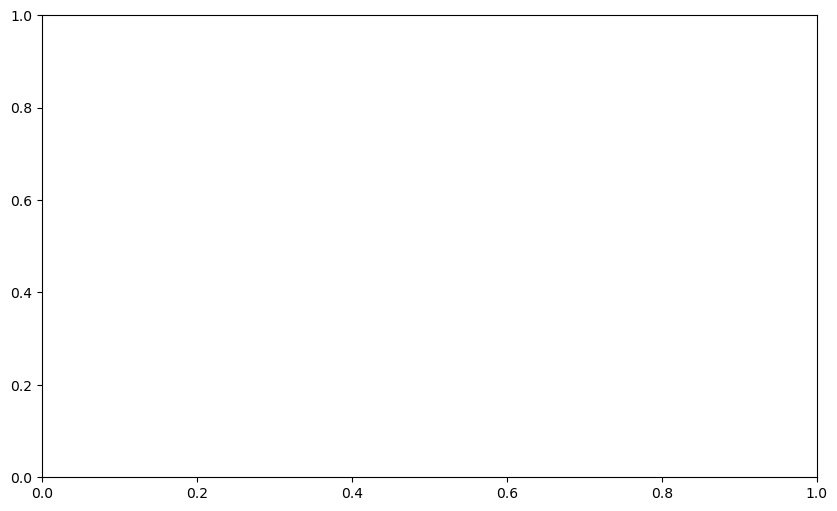

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the KDEs
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

data = SAT_trend['P1'].values.flatten()

sns.kdeplot(data=data, ax=ax, label='DJF Trends')

ax.set_xlabel('Slope (K/yr)')
ax.set_ylabel('Density')
plt.show()

# Save the figure
fig.savefig('DJF-trends-kde-comparison.png', dpi=300)
